# Reconstructing a Helix in 3D

In [1]:
using Revise, TaD, LinearAlgebra, Plots

┌ Info: Precompiling TaD [e673c115-fdda-452a-a923-4f686bacb4c9]
└ @ Base loading.jl:1423
┌ Warning: Package TaD does not have IterativeSolvers in its dependencies:
│ - If you have TaD checked out for development and have
│   added IterativeSolvers as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TaD
└ Loading IterativeSolvers into TaD from project dependency, future warnings for TaD are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `TaD.BSplineBasis :: Union{}` in module `TaD`
└ @ Base.Docs docs/Docs.jl:240
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation ma

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



## N=100 Steps

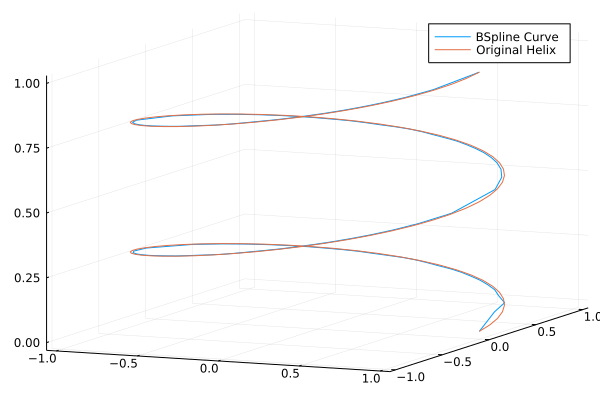

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [2]:
n = 100
helix = construct_helix(n)
Curve = reconstruct_trajectory(helix)
plot(Curve, label="BSpline Curve")
plot!(tuple(eachcol(helix)...), label="Original Helix")

## N=1000 Steps

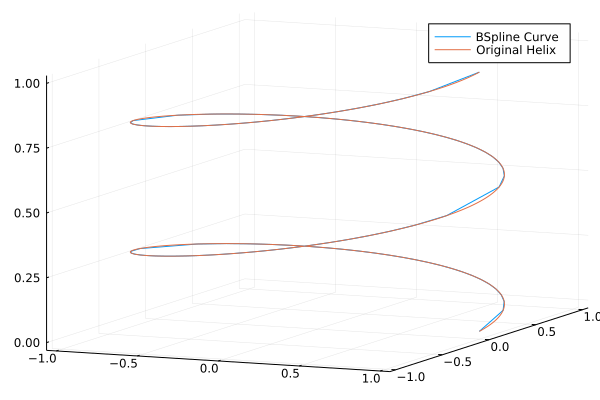

In [3]:
n = 10000
helix = construct_helix(n)
Curve = reconstruct_trajectory(helix)
plot(Curve, label="BSpline Curve")
plot!(tuple(eachcol(helix)...), label="Original Helix")

## Error Analysis

## Isolating First Dimension

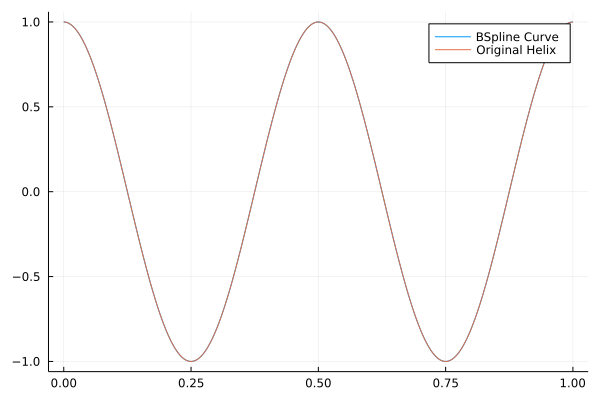

In [4]:
evals = evaluate(Curve, length(helix[:,1]))
plot(evals[:,3], evals[:,1], label="BSpline Curve")
plot!(helix[:,3], helix[:,1], label="Original Helix")

### Error Analysis using 'Norm' from LinearAlgebra.jl

In [5]:
resolutions = 100:100:5000
scaled_norm = zeros(length(collect(resolutions)))
for (i, resolution) in enumerate(resolutions)
    helix = construct_helix(resolution)
    Curve = reconstruct_trajectory(helix)
    evals = evaluate(Curve, length(helix[:,1]))
    scaled_norm[i] = norm(helix-evals)/resolution
end

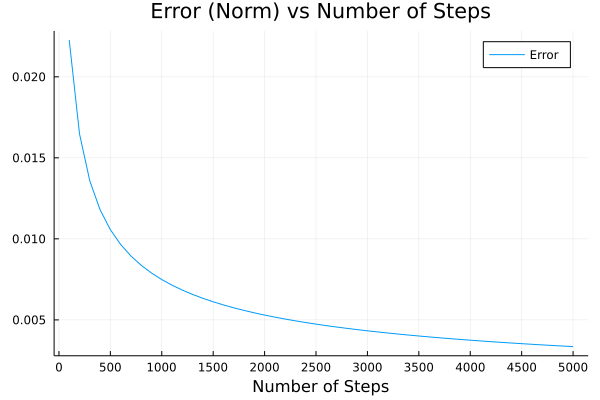

In [6]:
plot(resolutions, scaled_norm, label="Error", title="Error (Norm) vs Number of Steps", xlabel="Number of Steps", xticks=0:500:5000)

### Error Analysis using L2 Norm

In [8]:
#The cumulative sum of the error in each dimension
resolutions = 100:100:5000
scaled_L2 = zeros(length(collect(resolutions)))
for (i, resolution) in enumerate(resolutions)
    helix = construct_helix(resolution)
    Curve = reconstruct_trajectory(helix)
    evals = evaluate(Curve, length(helix[:,1]))
    error = cumsum(L2error(Curve, helix))[end];
    scaled_L2[i] = error
end

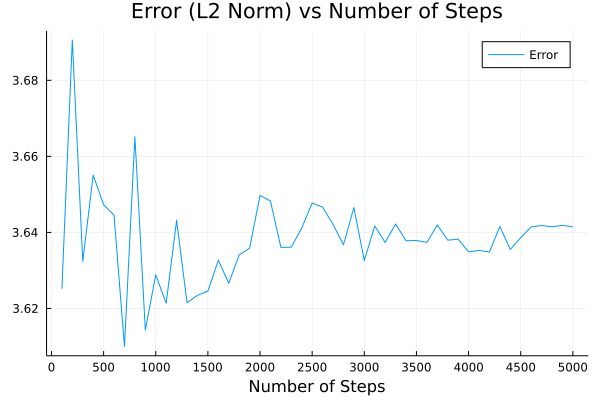

In [9]:
plot(resolutions, scaled_L2, label="Error", title="Error (L2 Norm) vs Number of Steps", xlabel="Number of Steps", xticks=0:500:5000)